In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, utils

Reusing code from previous task.

In [2]:
# Creating data frames for both csv files
genotypes_df = pd.read_csv(
    'data/genotypes.csv'
)
phenotypes_df = pd.read_csv(
    'data/phenotype_df.csv',
    usecols=[4]
)
annotations_df = pd.read_csv(
    'data/annotations.csv'
)

# Transposing the frame
genotypes_df = genotypes_df.T

# Extracting first row to assign new headers
headers = genotypes_df.iloc[0]

# Removing the first row with old headers
genotypes_df = genotypes_df[1:]

# Inserting our new headers
genotypes_df.columns = headers

# Sample id has become the new df index
genotypes_df.reset_index(inplace=True)  # We want it to be a column for renaming

# Internal index name removed (not necessary)
genotypes_df.index.name = None

# Renaming for later joint
genotypes_df.rename(columns={'index':'variant_id'}, inplace=True)

merged_df = pd.merge(annotations_df, genotypes_df, on='variant_id')

# Grouping by genes
grouped_df = merged_df.groupby('gene_name')

# Empty frame
gene_burdens = pd.DataFrame()

for gene_name, group in grouped_df:
    # Weighted sum (I am assuming the 'alpha_missense' values are the weights)
    gene_burden = (group.iloc[:, 3:] * group['alpha_missense'].values[:, None]).sum()
    
    # Append the computed gene burden to its respective gene
    gene_burdens[gene_name] = gene_burden

In [3]:
# Shuffling the matrices values for uniform random sampling
g = gene_burdens.values.astype(float)
p = phenotypes_df.values

# Shuffling indices along columns
indices = np.arange(len(g))
np.random.shuffle(indices)

# Reordering with new indices
g = g[indices]
p = p[indices]

# Calculatign the index required for the split
split_index = int(0.8 * len(g))

g_tr = g[:split_index]  
g_te = g[split_index:]

p_tr = p[:split_index]
p_te = p[split_index:]

print(g_tr.shape)
print(g_te.shape)

(1600, 50)
(400, 50)


In [4]:
def linear_regression(X, y, alpha):

    X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
    _, n_features = X.shape

    # L2 regularization
    
    I = np.eye(n_features) # Creating an identity matrix of size n_features to allow for matrix addition
    theta = np.linalg.solve(X.T @ X + alpha * I , X.T @ y)

    yhat = X @ theta

    train_error = np.mean((yhat - y) ** 2)

    print("Training error:" , train_error)

    return theta, yhat

In [5]:
theta, yhat_train = linear_regression(g_tr, p_tr, 0.1)

Training error: 0.903210609858731


In [7]:
X_te = g_te

X_te = np.concatenate([np.ones((X_te.shape[0], 1)), X_te], axis=1)

yhat_test = X_te @ theta

test_error = np.mean((yhat_test - p_te) ** 2)

print("Testing error:", test_error)

Testing error: 0.9497917222913486


In [8]:
train_g_tensor = torch.from_numpy(g_tr)
train_p_tensor = torch.from_numpy(p_tr)

train_dataset = utils.data.TensorDataset(
    train_g_tensor,
    train_p_tensor
)

test_g_tensor = torch.from_numpy(g_te)
test_p_tensor = torch.from_numpy(p_te)

test_dataset = utils.data.TensorDataset(
    test_g_tensor,
    test_p_tensor
)

train_dataloader = utils.data.DataLoader(
    train_dataset,
    batch_size=40,
    shuffle=True
)

test_dataloader = utils.data.DataLoader(
    test_dataset,
    batch_size=40,
    shuffle=False
)

In [71]:
class MyNN(nn.Module):
  def __init__(self, ni, nh1, nh2, nh3, nh4, no):
    super().__init__()
    self.layer1 = nn.Linear(ni,nh1)
    
    self.layer2 = nn.Linear(nh1, nh2)

    self.layer3 = nn.Linear(nh2, nh3)

    self.layer4 = nn.Linear(nh3, nh4)

    self.layer5 = nn.Linear(nh4, no)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    
    x = self.layer2(x)
    x = self.relu(x)

    x = self.layer3(x)
    x = self.relu(x)

    x = self.layer4(x)
    x = self.relu(x)

    x = self.layer5(x)

    return x

In [72]:
def train(dataloader, n_epoch, net, opt, device):
  ls = []
  loss_function = nn.MSELoss()  # MSE loss for linear regression
  
  for i in range(n_epoch):
    total_loss = 0
    for batch in dataloader:
      X, y = batch[0].to(device).float(), batch[1].to(device).float()
      yhat = net(X)
      loss = loss_function(yhat, y)
      opt.zero_grad()
      loss.backward()
      opt.step()

      total_loss += loss.item()
      
    ls.append(total_loss/len(dataloader))

  plt.plot(ls)
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

  return ls[len(ls)-1]

In [124]:
device = torch.device("cuda:0")
net = MyNN(50, 40, 30, 25, 15, 1).to(device)
opt = optim.SGD(net.parameters(), lr = 1e-2 , momentum = 0)

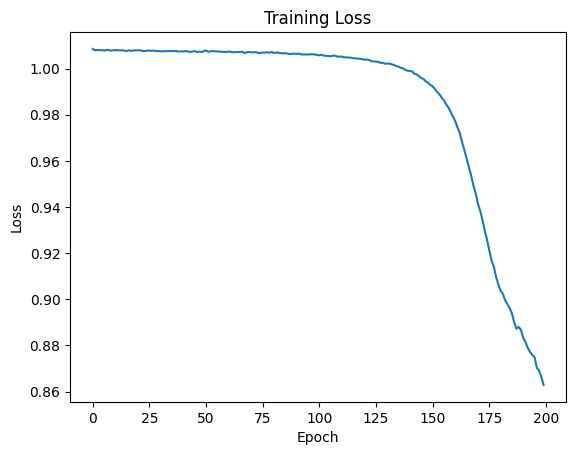

In [125]:
train_loss = train(train_dataloader, 200, net, opt, device)

In [126]:
print("Final train loss: ", train_loss)

Final train loss:  0.8629010379314422


In [127]:
def test(dataloader, net):
  net.eval()
  loss_function = nn.MSELoss()  # MSE loss for linear regression
  with torch.no_grad():
    total_loss = 0
    for batch in dataloader:
      X, y = batch[0].to(device).float(), batch[1].to(device).float()
      yhat = net(X)
      loss = loss_function(yhat, y)
      total_loss += loss.item()

    return total_loss/len(dataloader)

In [128]:
test_loss = test(test_dataloader, net)
print("Test loss: ", test_loss)

Test loss:  0.9692157924175262


Because the gene burdens account for only a small fraction of the total variability in LDL levels, we can see that there is little to no improvement between using a simple linear model and a fully connected neural network.